In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

In [2]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
from tensorflow import keras
from tensorflow.keras import backend as K

# Variational Auto Encoder (VAE)

In [4]:
# loading the MNSIT data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

11493376/11490434 [==============================] - 1s 0us/step


In [5]:
# network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

In [7]:
# encoder
x = keras.Input(shape=(x_train.shape[1:]))
x_encoded = keras.layers.Dense(n_hidden, activation='relu')(x)
x_encoded = keras.layers.Dense(n_hidden//2, activation='relu')(x_encoded)

mu = keras.layers.Dense(z_dim)(x_encoded)
log_var = keras.layers.Dense(z_dim)(x_encoded)

In [8]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1)
    return mu + K.exp(log_var) * eps

z = keras.layers.Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [11]:
# decoder
z_decoder1 = keras.layers.Dense(n_hidden//2, activation='relu')
z_decoder2 = keras.layers.Dense(n_hidden, activation='relu')
y_decoder = keras.layers.Dense(x_train.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [12]:
# loss
reconstruction_loss = keras.losses.mse(x, y) * x_train.shape[1]
kl_loss = 0.5 * K.mean(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model (that goes x -> y)
vae = keras.Model(x, y)
vae.add_loss(vae_loss)

vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
______________________________________________________________________________________________

In [13]:
optimizer = keras.optimizers.Adam(0.001)
vae.compile(optimizer=optimizer)

In [15]:
# train the model
vae.fit(x_train,
       shuffle=True,
       epochs=100,
       batch_size=batch_size,
       validation_data=(x_test, None), verbose=1)

Epoch 1/100
600/600 [==============================] - 3s 5ms/step - loss: 49.8296 - val_loss: 42.2333
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - loss: 40.4988 - val_loss: 39.0828
Epoch 3/100
600/600 [==============================] - 3s 5ms/step - loss: 38.2522 - val_loss: 37.4586
Epoch 4/100
600/600 [==============================] - 3s 5ms/step - loss: 36.7401 - val_loss: 36.0458
Epoch 5/100
600/600 [==============================] - 3s 5ms/step - loss: 35.7372 - val_loss: 35.3357
Epoch 6/100
600/600 [==============================] - 3s 5ms/step - loss: 35.0568 - val_loss: 34.7580
Epoch 7/100
600/600 [==============================] - 3s 5ms/step - loss: 34.5724 - val_loss: 34.2499
Epoch 8/100
600/600 [==============================] - 3s 5ms/step - loss: 34.0925 - val_loss: 33.9663
Epoch 9/100
600/600 [==============================] - 3s 5ms/step - loss: 33.5680 - val_loss: 33.5065
Epoch 10/100
600/600 [==============================] - 3s 5ms/step - los

In [17]:
# build individual parts of our Model
encoder = keras.Model(x, mu)
var_encoder = keras.Model(x, log_var)
sampler = keras.Model(x, z)

# build generator
decoder_input = keras.Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = keras.Model(decoder_input, _y)

Plot of the digit classes in the latent space

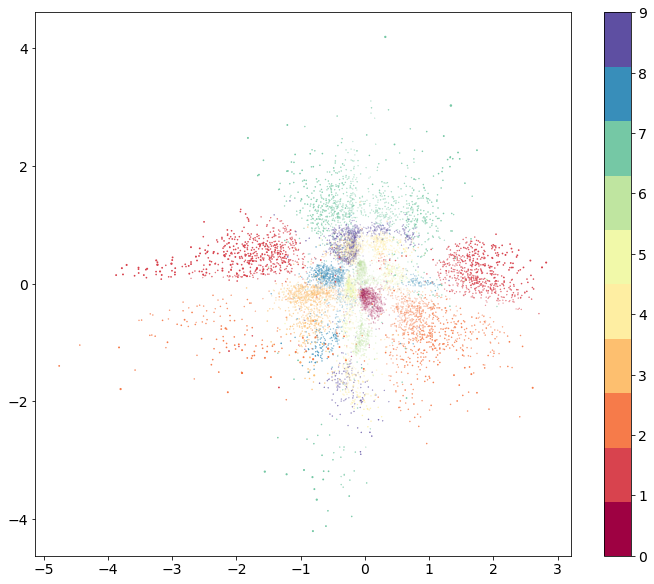

In [18]:
x_test_latent = encoder.predict(x_test, batch_size=batch_size)
x_test_logvar = var_encoder.predict(x_test, batch_size=batch_size)
x_test_var = np.exp(np.sum(x_test_logvar, axis=-1))
plt.figure(figsize=(12, 10))
plt.scatter(x_test_latent[:, 0], x_test_latent[:, 1], s=x_test_var*100, c=y_test, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
#plt.savefig('mnist_vae_2d_true_labels.png', bbox_inches='tight')

And we can look at random samples

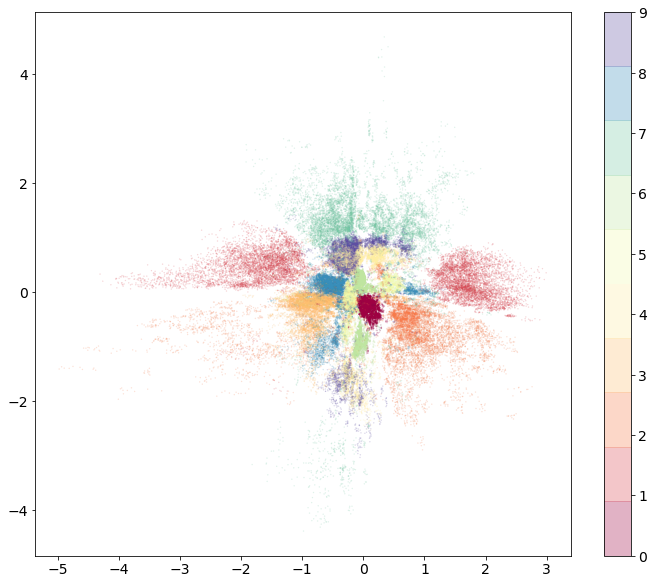

In [21]:
plt.figure(figsize=(12, 10))
for i in range(10):
    z_test_latent = sampler.predict(x_test, batch_size=batch_size)
    plt.scatter(z_test_latent[:, 0], z_test_latent[:, 1], s=0.1, alpha=0.3, c=y_test, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar()
#plt.savefig('mnist_vae_2d_sampled_space.png', bbox_inches='tight')

Plot of the digit classes in the latent space, which we can see follow quite nicely unit normals

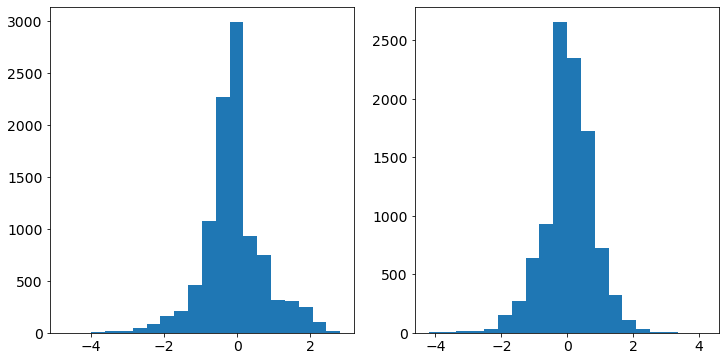

In [22]:
x_test_latent = encoder.predict(x_test, batch_size=batch_size)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].hist(x_test_latent[:, 0], bins=20)
ax[1].hist(x_test_latent[:, 1], bins=20);

Now we can try to artificially generate new digits. Here we just sample form a regular grid that nicely covers the space formed by a 2d unit normal

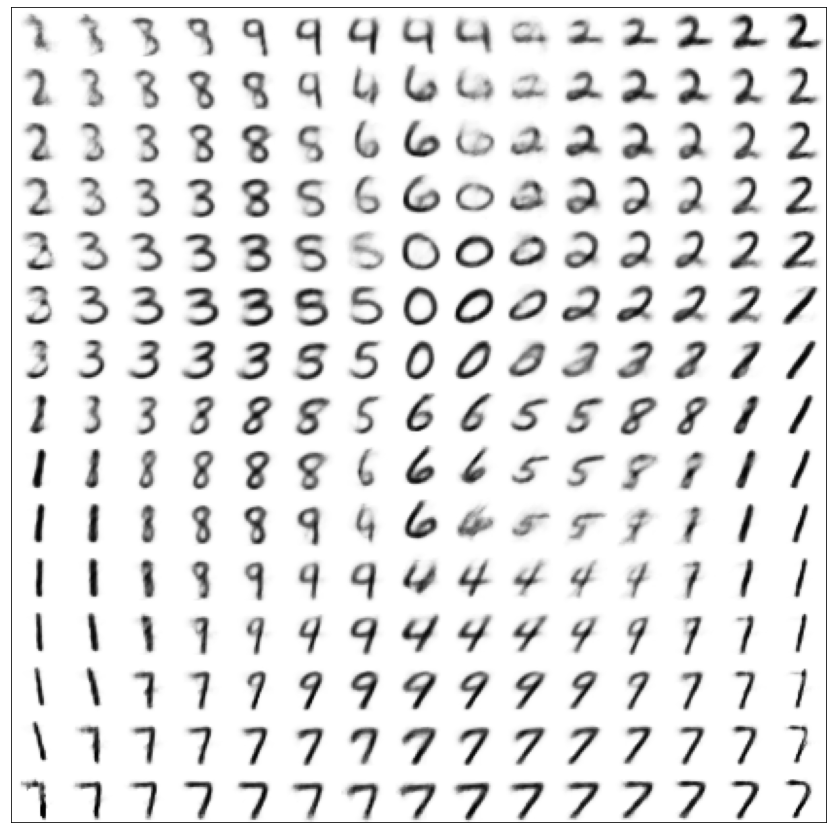

In [23]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = stats.norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = stats.norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys')

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)


#plt.savefig('VAE_mnist.png', bbox_inches='tight')